<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»
Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Необходимо обучить модель классифицировать комментарии на позитивные и негативные.

И построить модель со значением метрики качества *F1* не меньше 0.75. 

## Подготовка

In [1]:
!pip install wordcloud

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import pandas as pd
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import wordnet, stopwords

import nltk
import re
import torch
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import notebook

from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


from sklearn import preprocessing
from sklearn import feature_selection 
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, roc_auc_score, roc_curve, precision_score, recall_score, precision_recall_curve


In [3]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv')
#df = pd.read_csv('/home/arteev/ds/DS_course/toxic_comments.csv')

#df = df.sample(120000).reset_index(drop=True)
display(df)
print()
print(df.info())
print()
print(df.describe())

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
...,...,...
159566,""":::::And for the second time of asking, when ...",0
159567,You should be ashamed of yourself \n\nThat is ...,0
159568,"Spitzer \n\nUmm, theres no actual article for ...",0
159569,And it looks like it was actually you who put ...,0



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
text     159571 non-null object
toxic    159571 non-null int64
dtypes: int64(1), object(1)
memory usage: 2.4+ MB
None

               toxic
count  159571.000000
mean        0.101679
std         0.302226
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000


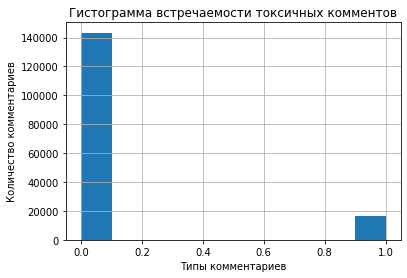

In [4]:
df['toxic'].hist()
plt.title("Гистограмма встречаемости токсичных комментов")

plt.ylabel("Количество комментариев")
plt.xlabel("Типы комментариев")
plt.show()

<div class="alert alert-success">
<h1> Комментарий ревьюера <a class="tocSkip"></h1>
Да, налицо явный дисбаланс классов
</div>

#### Вывод
- в тексте присутствует много лишних символов
- присутствует дисбаланс классов
- пропусков нет
- типы данных в порядке

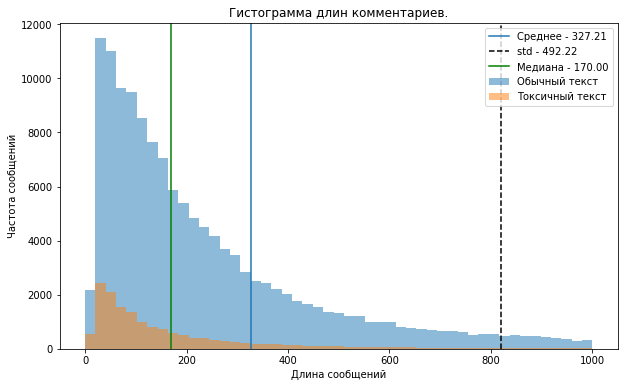

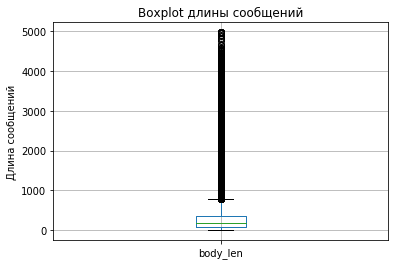

In [5]:
bins=np.linspace(0,1000,50)

df['body_len'] = df['text'].apply(lambda x: len(x)-x.count(" "))
plt.subplots(figsize=(10,6))

plt.hist(df[df['toxic']==0]['body_len'], bins, alpha=0.5, label='Обычный текст')
plt.hist(df[df['toxic']==1]['body_len'], bins, alpha=0.5, label='Токсичный текст')

plt.title('Гистограмма длин комментариев.')
plt.ylabel('Частота сообщений')
plt.xlabel('Длина сообщений')
plt.axvline(df['body_len'].mean(), label=("Среднее - {:.2f}".format(df['body_len'].mean())))
plt.axvline(df['body_len'].mean()+df['body_len'].std(), linestyle="--", color="k", label=("std - {:.2f}".format(df['body_len'].std())))
plt.axvline(df['body_len'].median(), linestyle="-", color="g", label=("Медиана - {:.2f}".format(df['body_len'].median())))

plt.legend(loc='upper right')
plt.show()

df.boxplot(column='body_len')
plt.title("Boxplot длины сообщений")
plt.ylabel("Длина сообщений")
plt.show()

#### Вывод
- токсичные комментарии отличаются по длине и количеству. Они более короткие и их меньше.

## Предобработка данных

#### Удалим текста длиной более 2000 символов

In [6]:
df = df.drop(df[df['body_len']>2000].index)
print(df.count())

text        156559
toxic       156559
body_len    156559
dtype: int64


In [7]:
nltk.download('stopwords')

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

wnl = WordNetLemmatizer()
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('punkt')

def lemmatizer(text):
    return " ".join([wnl.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(text)])


def clear_text(text):
    return " ".join(re.sub(r'[^a-zA-Z]', ' ', text).split())

df['clear_text'] = df['text'].apply(clear_text)
df['lower_text'] = df['clear_text'].apply(lambda s: s.lower())
df['lemm_text'] = df['lower_text'].apply(lemmatizer)

display(df.head())

df = df.drop(columns = ['clear_text'], axis=1)

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,text,toxic,body_len,clear_text,lower_text,lemm_text
0,Explanation\nWhy the edits made under my usern...,0,223,Explanation Why the edits made under my userna...,explanation why the edits made under my userna...,explanation why the edits make under my userna...
1,D'aww! He matches this background colour I'm s...,0,95,D aww He matches this background colour I m se...,d aww he matches this background colour i m se...,d aww he match this background colour i m seem...
2,"Hey man, I'm really not trying to edit war. It...",0,192,Hey man I m really not trying to edit war It s...,hey man i m really not trying to edit war it s...,hey man i m really not try to edit war it s ju...
3,"""\nMore\nI can't make any real suggestions on ...",0,511,More I can t make any real suggestions on impr...,more i can t make any real suggestions on impr...,more i can t make any real suggestion on impro...
4,"You, sir, are my hero. Any chance you remember...",0,55,You sir are my hero Any chance you remember wh...,you sir are my hero any chance you remember wh...,you sir be my hero any chance you remember wha...


#### Чистка текста
- почистили текст от лишних символов
- привели к нижнему регистру
- лемматизировали текст
- удалили текста с длиной > 2000 символов

In [8]:
stop_words = set(stopwords.words('english'))

toxic_text = " ".join(text for text in df[df['toxic']==1]['lemm_text'])
normal_text = " ".join(text for text in df[df['toxic']==0]['lemm_text'])

toxic_wordcloud = WordCloud(stopwords=stop_words).generate(toxic_text)
normal_wordcloud = WordCloud(stopwords=stop_words).generate(normal_text)



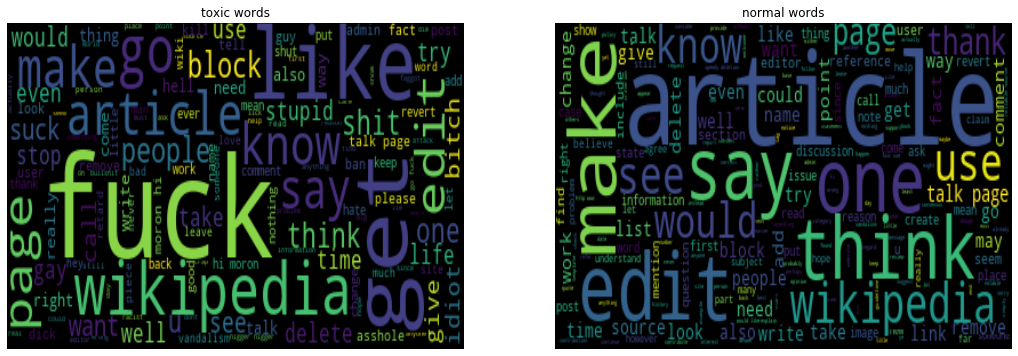

In [9]:
fig, ax =plt.subplots(1,2, figsize=(18,6))
ax[0].imshow(toxic_wordcloud, interpolation='bilinear', aspect="auto")
ax[0].axis("off")
ax[0].title.set_text("toxic words")
ax[1].imshow(normal_wordcloud, interpolation='bilinear', aspect="auto")
ax[1].axis("off")
ax[1].title.set_text("normal words")

plt.show()

In [10]:
train_features, test_features, train_target, test_target = train_test_split(df['lemm_text'], df['toxic'], test_size=0.2, random_state=12345, stratify=df['toxic'])
train_features, val_features, train_target, val_target = train_test_split(train_features, train_target, test_size=0.25, random_state=12345, stratify=train_target)

def reset_indexes(df):
    return df.reset_index(drop=True)


train_corpus = reset_indexes(train_features).values.astype('U')
test_corpus = reset_indexes(test_features).values.astype('U')
val_corpus = reset_indexes(val_features).values.astype('U')

train_target = reset_indexes(train_target)
test_target = reset_indexes(test_target)
val_target = reset_indexes(val_target)


### Векторизация текста

In [11]:
tfidf_vectorizer = TfidfVectorizer( stop_words=stop_words) 

In [12]:
tfidf_vectorizer.fit(train_corpus)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True,
                stop_words={'a', 'about', 'above', 'after', 'again', 'against',
                            'ain', 'all', 'am', 'an', 'and', 'any', 'are',
                            'aren', "aren't", 'as', 'at', 'be', 'because',
                            'been', 'before', 'being', 'below', 'between',
                            'both', 'but', 'by', 'can', 'couldn', "couldn't", ...},
                strip_accents=None, sublinear_tf=False,
                token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
                vocabulary=None)

In [13]:
train_features =  tfidf_vectorizer.transform(train_corpus)
test_features = tfidf_vectorizer.transform(test_corpus)
val_features = tfidf_vectorizer.transform(val_corpus)

In [14]:
print(train_features.shape, test_features.shape, val_features.shape)

(93935, 99731) (31312, 99731) (31312, 99731)


#### Итог векторизации
- разделили датасет на train и test
- инициализировали модель векторизации TF-IDF с удалением стоп слов
- преобразовали тексты в векторы

In [15]:
def calc_scores(true, predict):
    scores_dict = {}
    scores_dict['f1'] = f1_score(true, predict)
    scores_dict['precis'] = precision_score(true, predict)
    scores_dict['recall'] = recall_score(true, predict)
    scores_dict['roc_auc'] = roc_auc_score(true, predict)
    return scores_dict

def print_scores(scores_dict):
    print("   F1_score  {:.2f}".format(scores_dict['f1']))
    print("   Precision  {:.2f}".format(scores_dict['precis']))
    print("   Recall {:.2f}".format(scores_dict['recall']))
    print("   ROC-AUC {:.2f}".format(scores_dict['roc_auc']))
    
    
def predict_and_score(features, target):
    predictions = model.predict(features)

    scores = calc_scores(target, predictions)        
    print_scores(scores)
    return scores

## Обучение
Обучим следующие модели  LogisticRegression, LinearSVC, DecisionTree

In [16]:
final_report = {}

In [17]:
%%time

model = LogisticRegression(random_state=12345, max_iter=1000)
model.fit(train_features, train_target)

predicted_probabilities = model.predict_proba(val_features)


probabilities_once = predicted_probabilities[:, 1]
max_f1 = 0
scores = {}
f1_list = []
for threashold in np.arange(0.1, 0.3, 0.02):
    predicted_valid = probabilities_once>threashold
    f1 = f1_score(val_target, predicted_valid)
    f1_list.append(f1)
    
    if f1 > max_f1:
        max_f1 = f1
        best_treashold = threashold
        scores = calc_scores(val_target, predicted_valid)

print("LogisticRegression")
print("Best threshold ", best_treashold)       
print_scores(scores)

print()
print("Predict with best threshold")
predicted_probabilities = model.predict_proba(test_features)

probabilities_once = predicted_probabilities[:, 1]
predictions = probabilities_once>best_treashold

scores = calc_scores(test_target, predictions) 
print_scores(scores)

final_report[type(model).__name__ + " (Best tresh)"] = scores

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression
Best threshold  0.28
   F1_score  0.78
   Precision  0.83
   Recall 0.73
   ROC-AUC 0.86

Predict with best threshold
   F1_score  0.77
   Precision  0.82
   Recall 0.73
   ROC-AUC 0.85
CPU times: user 5.43 s, sys: 3.45 s, total: 8.87 s
Wall time: 8.91 s


Text(0, 0.5, 'F1')

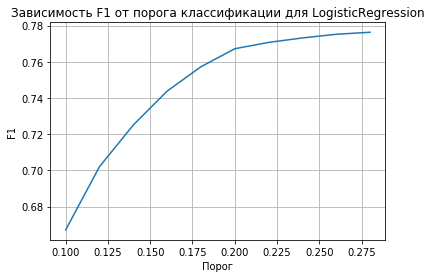

In [18]:
plt.plot(np.arange(0.1, 0.3, 0.02), f1_list)
plt.grid()
plt.title("Зависимость F1 от порога классификации для LogisticRegression")
plt.xlabel("Порог")
plt.ylabel("F1")

In [19]:
%%time

model = LogisticRegression(random_state=12345, max_iter=1000, class_weight='balanced')
model.fit(train_features, train_target)

steps = [('vectorizer', tfidf_vectorizer), ('model', model)]

pipeline = Pipeline(steps)
cross_score = cross_val_score(pipeline, train_corpus, train_target, cv=5, scoring='f1')

print("LogisticRegression cross_val score {:.2f}".format(cross_score.sum()/len(cross_score)))

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

LogisticRegression cross_val score 0.74
CPU times: user 1min 12s, sys: 34.1 s, total: 1min 47s
Wall time: 1min 48s


In [20]:
predictions = model.predict(test_features)

In [21]:
scores = calc_scores(test_target, predictions)        
print_scores(scores)
final_report[type(model).__name__] = scores

   F1_score  0.74
   Precision  0.67
   Recall 0.84
   ROC-AUC 0.90


#### Вывод

- LogisticRegression показала хороший score = 0.77

#### LinearSVC

In [22]:
%%time
model = LinearSVC(random_state=12345, class_weight='balanced')
model.fit(train_features, train_target)

print("LinearSVC. Train scores")
scores = predict_and_score(train_features, train_target)

LinearSVC. Train scores
   F1_score  0.92
   Precision  0.85
   Recall 0.99
   ROC-AUC 0.99
CPU times: user 3.46 s, sys: 0 ns, total: 3.46 s
Wall time: 3.48 s


In [23]:
print("LinearSVC. Test scores")

scores = predict_and_score(test_features, test_target)
final_report[type(model).__name__] = scores

LinearSVC. Test scores
   F1_score  0.75
   Precision  0.70
   Recall 0.80
   ROC-AUC 0.88


#### Decision Tree

In [24]:
parametrs = { 'max_depth': range (150, 200, 50)}
              #'min_samples_leaf': range (2,14, 2)}
 #             'min_samples_split': range (2,8,2) }

In [25]:
%%time

model = DecisionTreeClassifier(random_state=12345, max_depth=150, min_samples_leaf=6, min_samples_split=2)
grid = GridSearchCV(model, parametrs, scoring="f1", n_jobs=-1, verbose = 3, cv=3)
grid.fit(train_features, train_target)

predictions = grid.predict(test_features)

print("Decision Tree. Train scores")
scores = calc_scores(test_target, predictions)

final_report[type(model).__name__] = scores

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] max_depth=150 ...................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ....................... max_depth=150, score=0.710, total=  48.8s
[CV] max_depth=150 ...................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   48.8s remaining:    0.0s


[CV] ....................... max_depth=150, score=0.703, total=  47.7s
[CV] max_depth=150 ...................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  1.6min remaining:    0.0s


[CV] ....................... max_depth=150, score=0.708, total=  48.2s


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.4min finished


Decision Tree. Train scores
CPU times: user 3min 36s, sys: 188 ms, total: 3min 37s
Wall time: 3min 37s


In [26]:
print("Final report")

report = pd.DataFrame(final_report)
display(report.round(2))


Final report


,LogisticRegression (Best tresh),LogisticRegression,LinearSVC,DecisionTreeClassifier
f1,0.77,0.74,0.75,0.71
precis,0.82,0.67,0.70,0.77
recall,0.73,0.84,0.80,0.65
roc_auc,0.85,0.90,0.88,0.81


## Выводы
- Лучший скор показала LogisticRegression 0.77, а лучшее время LinearSVC 3s с результатом 0.76
- DecisionTree обучается дольше всех и сильно переобучается, что видно на результате предсказания по train F1=1 и test F1=0.71
- Лемматизация занимает очень много времени и не дает хорошей прибавки к f1.


## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Модели обучены
- [x]  Значение метрики *F1* не меньше 0.75
- [x]  Выводы написаны